In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
from typing import Optional
import matplotlib
import numpy as np
import pymcr
import torch

import matplotlib.pyplot as plt
from pymcr.mcr import McrAR
from pymcr.constraints import ConstraintNonneg, ConstraintNorm
from pymcr.regressors import LinearRegression
from numpy.typing import NDArray
import torch.nn as nn


print("Python version: ", sys.version)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("pymcr version: ", pymcr.__version__)
print("torch version", torch.__version__)

Python version:  3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
numpy version:  1.26.3
matplotlib version:  3.8.2
pymcr version:  0.5.1
torch version 2.5.0


In [3]:
# Is slower
# if torch.mps.is_available():
#     torch.set_default_device("mps")

torch.set_default_dtype(torch.float64)

In [ ]:
import itertools


class TorchLeastSquares(LinearRegression):
    """
    Simple example class using pytorch to create a model compatible with pyMCR.

    This inherits from the LinearRegression abstract base class. and needs to implement the
    fit abstract method that takes two arguments A and B. The fit method should store the result
    from solving Ax=B into self.X_.
    """

    def __init__(self, *args, **kwargs):
        super().__init__()
        self.rank = None
        self.sv = None

    def fit(self, A: NDArray, B: NDArray):
        """ "
        Solve Ax=B using pytorch least squares. A and B are numpy arrays, so must be converted to pytorch Tensors.

        Once X is solved for the result needs to be converted back into numpy arrays and stored in self.X_
        """
        A = torch.from_numpy(A)
        B = torch.from_numpy(B)

        X_, residuals, self.rank, self.sv = torch.linalg.lstsq(A, B)

        self.X_ = X_.numpy()
        self.residuals = residuals.numpy()


class Autoencoder(nn.Module):
    def __init__(self, n_features: int):
        super(Autoencoder, self).__init__()

        self.ac = torch.nn.ReLU()
        self.fc1 = nn.Linear(n_features, 128, dtype=torch.double)
        self.fc2 = nn.Linear(128, 128, dtype=torch.double)
        self.fc3 = nn.Linear(128, n_features, dtype=torch.double)

    def forward(self, x):
        x = self.ac(self.fc1(x))  # activation function for hidden layer
        x = self.ac(self.fc2(x))
        x = self.fc3(x)
        return x


class AutoEncoderAxB(LinearRegression):
    """
    Simple example class using pytorch to create a model compatible with pyMCR.

    This inherits from the LinearRegression abstract base class. and needs to implement the
    fit abstract method that takes two arguments A and B. The fit method should store the result
    from solving Ax=B into self.X_.
    """

    def __init__(self):
        super().__init__()
        self.x_ = torch.randn(2301, 2, dtype=torch.double, requires_grad=True)

        self.net = Autoencoder(n_features=2301)
        self.criterion = nn.MSELoss()

        # Changing to a smaller learning rate will shift the predicted spectra a lot
        self.optimizer = torch.optim.Adam(
            itertools.chain([self.x_], self.net.parameters()), lr=0.001
        )

    def fit(self, A: NDArray, B: NDArray):
        """ "
        Solve Ax=B using pytorch least squares. A and B are numpy arrays, so must be converted to pytorch Tensors.

        Once X is solved for the result needs to be converted back into numpy arrays and stored in self.X_
        """
        A = torch.from_numpy(A)
        B = torch.from_numpy(B)

        self.net.train()
        for _ in range(1000):
            x = self.net(self.x_.T)

            Axb = torch.matmul(A, x)
            loss = self.criterion(Axb, B)
            loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()

        self.net.eval()
        x = self.net(self.x_.T)
        self.X_ = x.detach().numpy().astype(np.float64)


class TorchGrad(LinearRegression):
    """
    Simple example class using pytorch to create a model compatible with pyMCR.

    This inherits from the LinearRegression abstract base class. and needs to implement the
    fit abstract method that takes two arguments A and B. The fit method should store the result
    from solving Ax=B into self.X_.
    """

    def __init__(
        self,
        lr: float = 0.01,
        n_iter: int = 1000,
        criterion: Optional[Any] = None,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.x_ = torch.randn(2, 2301, dtype=torch.double, requires_grad=True)
        if criterion is None:
            self.criterion = nn.MSELoss()
        else:
            self.criterion = criterion
        self.n_iter = n_iter

        # Changing to a smaller learning rate will shift the predicted spectra a lot
        self.optimizer = torch.optim.Adam([self.x_], lr=lr)

    def fit(self, A: NDArray, B: NDArray):
        """ "
        Solve Ax=B using pytorch least squares. A and B are numpy arrays, so must be converted to pytorch Tensors.

        Once X is solved for the result needs to be converted back into numpy arrays and stored in self.X_
        """
        A = torch.from_numpy(A)
        B = torch.from_numpy(B)

        # self.net.train()
        for _ in range(self.n_iter):
            Ax = torch.matmul(A, self.x_)
            loss = self.criterion(Ax, B)
            loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()

        # self.net.eval()
        self.X_ = self.x_.data.detach().numpy().astype(np.float64)

In [5]:
with open("./ethanol-mcr.npz", "rb") as ethanol_mcr_file:
    ethanol_mcr = np.load(ethanol_mcr_file)

    D = ethanol_mcr["D"]
    C = ethanol_mcr["C"]
    ST = ethanol_mcr["ST"]
    wavelengths = ethanol_mcr["wavelengths"]

    print(ethanol_mcr)

NpzFile 'object' with keys: D, C, ST, wavelengths


In [6]:
print(
    f"D shape: {D.shape}\nC shape: {C.shape}\nST shape{ST.shape}\nwavelengths shape: {wavelengths.shape}"
)

D shape: (55, 2301)
C shape: (55, 2)
ST shape(2, 2301)
wavelengths shape: (2301,)


## Predicting Concentrations from Pure Spectra

The fit errors due to the mean-squared error increasing above the tolerance. From what I understand, this means it finds the optimal value very quickly.

In [7]:
mcrar = McrAR(
    max_iter=100,
    st_regr=AutoEncoderAxB(),
    c_regr=TorchLeastSquares(),
    c_constraints=[ConstraintNonneg(), ConstraintNorm()],
    tol_increase=100.0,
)
mcrar.fit(D=D, ST=ST, verbose=True)

Iter: 1 (C)	mse: 2.9061e-04
Iter: 1 (ST)	mse: 1.9749e-04
Iter: 2 (C)	mse: 1.9809e-04
Iter: 2 (ST)	mse: 1.6048e-04
Iter: 3 (C)	mse: 1.6090e-04
Iter: 3 (ST)	mse: 1.4951e-04
Iter: 4 (C)	mse: 1.4949e-04
Iter: 4 (ST)	mse: 1.4933e-04
Iter: 5 (C)	mse: 1.4931e-04
Iter: 5 (ST)	mse: 1.5121e-04
Iter: 6 (C)	mse: 1.5117e-04
Iter: 6 (ST)	mse: 1.5988e-04
Iter: 7 (C)	mse: 1.6012e-04
Iter: 7 (ST)	mse: 1.4894e-04
Iter: 8 (C)	mse: 1.4895e-04
Iter: 8 (ST)	mse: 1.4901e-04
Iter: 9 (C)	mse: 1.4904e-04
Iter: 9 (ST)	mse: 1.4893e-04
Iter: 10 (C)	mse: 1.4898e-04
Iter: 10 (ST)	mse: 1.4898e-04
Iter: 11 (C)	mse: 1.4901e-04
Iter: 11 (ST)	mse: 1.4898e-04
Iter: 12 (C)	mse: 1.4903e-04
Iter: 12 (ST)	mse: 1.4901e-04
Iter: 13 (C)	mse: 1.4906e-04
Iter: 13 (ST)	mse: 1.4904e-04
Iter: 14 (C)	mse: 1.4909e-04
Iter: 14 (ST)	mse: 1.5223e-04
Half-iterated 11 times since min error. Exiting.


Text(0.5, 1.0, 'MCR-ALS Predictions based on Pure Spectra')

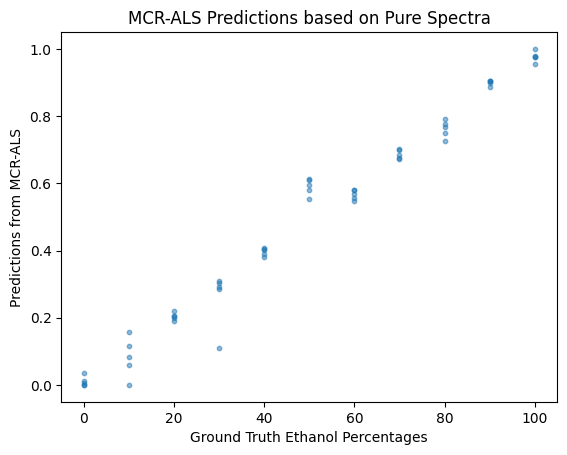

In [8]:
# I think its random whjch axis in C_opt_ gets which concentration
plt.scatter(x=C[:, 0], y=mcrar.C_opt_[:, 1], s=10, alpha=0.5)
plt.ylabel("Predictions from MCR-ALS")
plt.xlabel("Ground Truth Ethanol Percentages")
plt.title("MCR-ALS Predictions based on Pure Spectra")

## Predicting Pure Spectra from Concentration data

In this example I leave out the pure water and ethanol spectra that we already know. In the data matrix, these are the first 5 and last 5 samples. The 

In [9]:
mcrar = McrAR(
    max_iter=100,
    st_regr=AutoEncoderAxB(),
    c_regr=TorchLeastSquares(),
    # c_constraints=[ConstraintNonneg(), ConstraintNorm()],
    tol_increase=100.0,
)
mcrar.fit(D=D[5:-5, :], C=C[5:-5, :] / 100, verbose=True)

Iter: 1 (ST)	mse: 1.2789e-04
Iter: 2 (C)	mse: 1.1022e-04
Iter: 2 (ST)	mse: 1.0891e-04
Iter: 3 (C)	mse: 1.0940e-04
Iter: 3 (ST)	mse: 1.0970e-04
Iter: 4 (C)	mse: 1.0949e-04
Iter: 4 (ST)	mse: 1.1788e-04
Iter: 5 (C)	mse: 1.1486e-04
Iter: 5 (ST)	mse: 1.0953e-04
Iter: 6 (C)	mse: 1.0926e-04
Iter: 6 (ST)	mse: 1.0886e-04
Iter: 7 (C)	mse: 1.0878e-04
Iter: 7 (ST)	mse: 1.0843e-04
Iter: 8 (C)	mse: 1.0837e-04
Iter: 8 (ST)	mse: 1.1045e-04
Iter: 9 (C)	mse: 1.1015e-04
Iter: 9 (ST)	mse: 1.0898e-04
Iter: 10 (C)	mse: 1.0816e-04
Iter: 10 (ST)	mse: 1.1283e-04
Iter: 11 (C)	mse: 1.0872e-04
Iter: 11 (ST)	mse: 1.0794e-04
Iter: 12 (C)	mse: 1.0792e-04
Iter: 12 (ST)	mse: 1.0790e-04
Iter: 13 (C)	mse: 1.0789e-04
Iter: 13 (ST)	mse: 1.0787e-04
Iter: 14 (C)	mse: 1.0786e-04
Iter: 14 (ST)	mse: 1.1137e-04
Iter: 15 (C)	mse: 1.0864e-04
Iter: 15 (ST)	mse: 1.0788e-04
Iter: 16 (C)	mse: 1.0786e-04
Iter: 16 (ST)	mse: 1.0778e-04
Iter: 17 (C)	mse: 1.0778e-04
Iter: 17 (ST)	mse: 1.0778e-04
Iter: 18 (C)	mse: 1.0777e-04
Iter: 18 (ST)	

Text(0.5, 0, 'Wavelength (nm)')

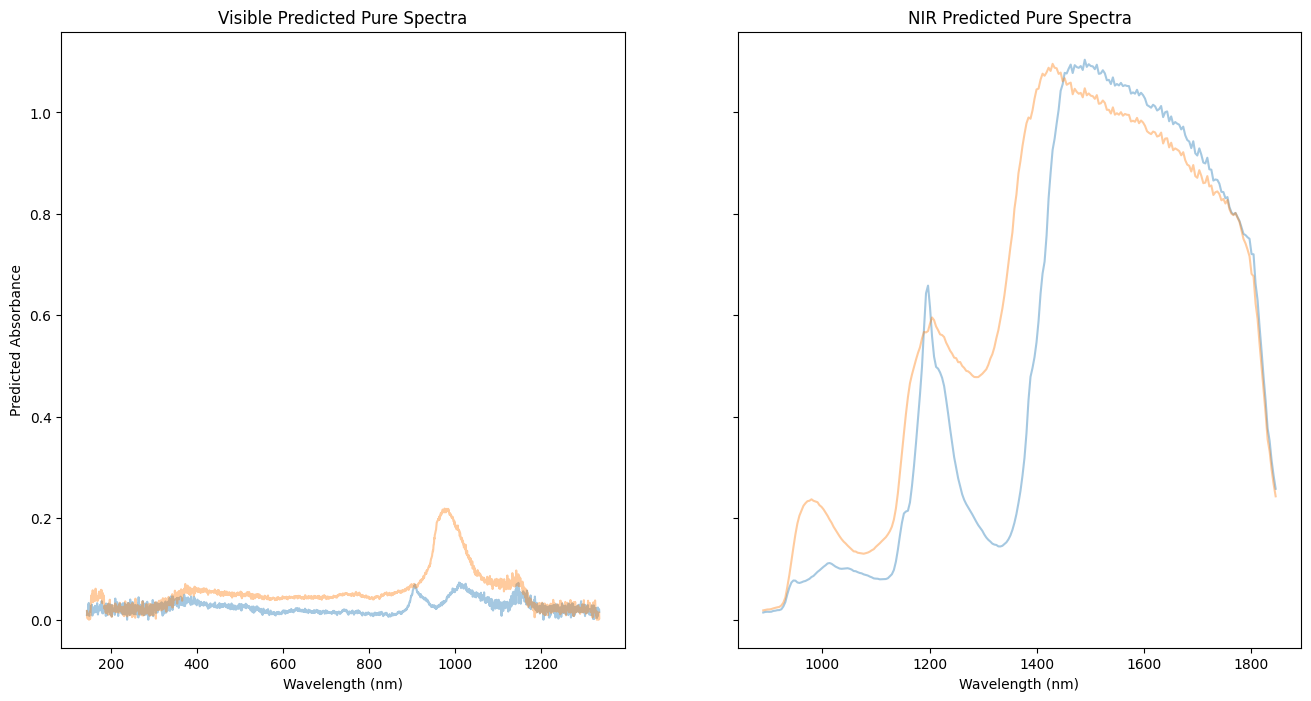

In [10]:
vis_cols = [
    float(col.split("_")[1]) for col in wavelengths if "avaspec" in col
]
nir_cols = [
    float(col.split("_")[1]) for col in wavelengths if "hamamatsu" in col
]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)

ax[0].plot(
    vis_cols,
    mcrar.ST_opt_[0, :2048],
    alpha=0.4,
)
ax[0].plot(
    vis_cols,
    mcrar.ST_opt_[1, :2048],
    alpha=0.4,
)

ax[1].plot(
    nir_cols,
    mcrar.ST_opt_[0, 2048:],
    alpha=0.4,
)
ax[1].plot(
    nir_cols,
    mcrar.ST_opt_[1, 2048:],
    alpha=0.4,
)

ax[1].set_title("NIR Predicted Pure Spectra")
ax[0].set_title("Visible Predicted Pure Spectra")
ax[0].set_ylabel("Predicted Absorbance")
ax[0].set_xlabel("Wavelength (nm)")
ax[1].set_xlabel("Wavelength (nm)")

## Lowering the learning rate to 0.001 and additional constraint

Iter: 1 (ST)	mse: 9.1389e-02
Iter: 2 (C)	mse: 7.2200e-02
Iter: 2 (ST)	mse: 5.9630e-02
Iter: 3 (C)	mse: 5.9446e-02
Iter: 3 (ST)	mse: 5.6479e-02
Iter: 4 (C)	mse: 5.5862e-02
Iter: 4 (ST)	mse: 5.3926e-02
Iter: 5 (C)	mse: 5.2534e-02
Iter: 5 (ST)	mse: 4.8928e-02
Iter: 6 (C)	mse: 4.6395e-02
Iter: 6 (ST)	mse: 3.9359e-02
Iter: 7 (C)	mse: 3.5734e-02
Iter: 7 (ST)	mse: 2.5661e-02
Iter: 8 (C)	mse: 2.2030e-02
Iter: 8 (ST)	mse: 1.2657e-02
Iter: 9 (C)	mse: 1.0387e-02
Iter: 9 (ST)	mse: 4.8915e-03
Iter: 10 (C)	mse: 4.0225e-03
Iter: 10 (ST)	mse: 1.8933e-03
Iter: 11 (C)	mse: 1.6738e-03
Iter: 11 (ST)	mse: 9.8963e-04
Iter: 12 (C)	mse: 9.2797e-04
Iter: 12 (ST)	mse: 6.2376e-04
Iter: 13 (C)	mse: 5.9938e-04
Iter: 13 (ST)	mse: 4.0690e-04
Iter: 14 (C)	mse: 3.9191e-04
Iter: 14 (ST)	mse: 2.6121e-04
Iter: 15 (C)	mse: 2.4923e-04
Iter: 15 (ST)	mse: 1.7313e-04
Iter: 16 (C)	mse: 1.6656e-04
Iter: 16 (ST)	mse: 1.3355e-04
Iter: 17 (C)	mse: 1.3167e-04
Iter: 17 (ST)	mse: 1.1948e-04
Iter: 18 (C)	mse: 1.1896e-04
Iter: 18 (ST)	

Text(0.5, 0, 'Wavelength (nm)')

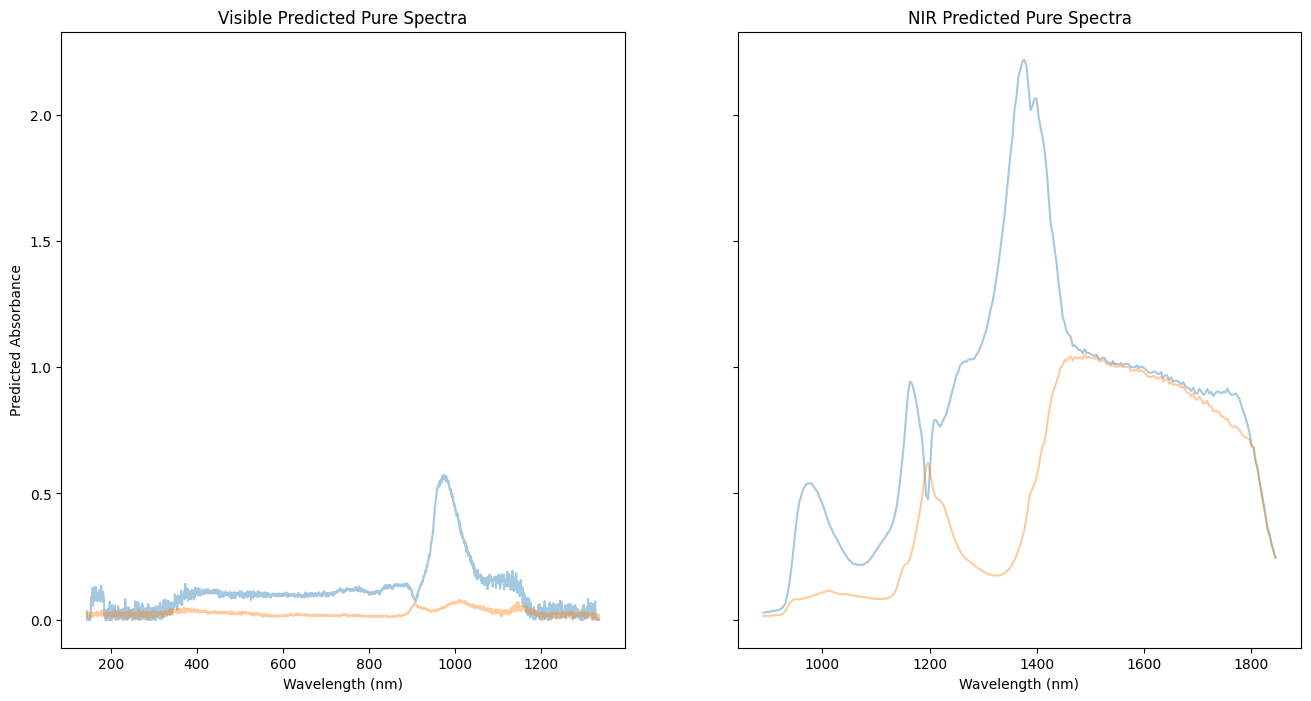

In [433]:
mcrar = McrAR(
    max_iter=1000,
    st_regr=TorchGrad(lr=0.001),
    c_regr=TorchLeastSquares(),
    c_constraints=[ConstraintNonneg(), ConstraintNorm()],
    tol_increase=100.0,
)
mcrar.fit(D=D[5:-5, :], C=C[5:-5, :] / 100, verbose=True)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)

ax[0].plot(
    vis_cols,
    mcrar.ST_opt_[0, :2048],
    alpha=0.4,
)
ax[0].plot(
    vis_cols,
    mcrar.ST_opt_[1, :2048],
    alpha=0.4,
)

ax[1].plot(
    nir_cols,
    mcrar.ST_opt_[0, 2048:],
    alpha=0.4,
)
ax[1].plot(
    nir_cols,
    mcrar.ST_opt_[1, 2048:],
    alpha=0.4,
)

ax[1].set_title("NIR Predicted Pure Spectra")
ax[0].set_title("Visible Predicted Pure Spectra")
ax[0].set_ylabel("Predicted Absorbance")
ax[0].set_xlabel("Wavelength (nm)")
ax[1].set_xlabel("Wavelength (nm)")